In [1]:
import os
import yaml
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from random import shuffle

In [2]:
# read patch bounds file
patch_bounds_file = '/home/terraloupe/yaml_files/nrw_dop10_stop_line_2nd_iteration_v1/patch_bounds_filtered_no_overlaps.geojson'

# read statistic file
df = pd.read_csv('/home/terraloupe/yaml_files/nrw_dop10_stop_line_2nd_iteration_v1/mask_stats.csv')

66064 65404 65404
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


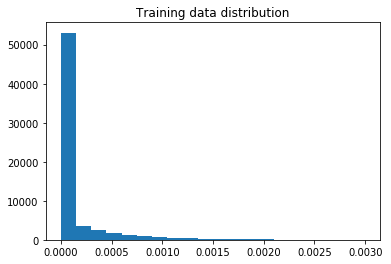

number of positives: 13264 ,number of negatives: 52140 ,ratio: 0.25439202148062906


In [4]:
# filter the statistic dataframe
polygon = gpd.read_file(patch_bounds_file)
patch_id = [os.path.split(x)[-1].split('.')[0] for x in list(np.array(polygon.location))]
polygon['patch_id'] = pd.Series(patch_id, index=polygon.index)
polygon.head()

df['total'] = pd.Series(np.array(df['background']) + np.array(df['Stop Line']), index=df.index)
df['percentage'] = pd.Series(np.array(df['Stop Line']) / np.array(df['total']), index=df.index) 
df_valid = df[df.filename.isin(np.array(polygon.patch_id).tolist())]
print(len(df), len(df_valid), len(polygon))
print('------------------------------------')

%pylab inline
plt.hist(df_valid['percentage'], bins=20, range=(0.0, 0.003))  # arguments are passed to np.histogram
plt.title("Training data distribution")
plt.show()

threshold = 0.0
positive_samples = df_valid[df_valid.percentage > threshold]
negative_samples = df_valid[df_valid.percentage <= threshold]
print('number of positives:', len(positive_samples), 
      ',number of negatives:', len(negative_samples), 
      ',ratio:', len(positive_samples)/len(negative_samples))

In [5]:
num_positives_to_val = 3000
num_negatives_to_val = 3000
num_negatives_to_train_sampling = 10000

positive_samples_files = list(positive_samples['filename'])
shuffle(positive_samples_files)
negative_samples_files = list(negative_samples['filename'])
shuffle(negative_samples_files)

val_positive_samples = positive_samples_files[0:num_positives_to_val]
val_negative_samples = negative_samples_files[0:num_negatives_to_val]
train_positive_samples = positive_samples_files[num_positives_to_val:]
train_negative_samples = negative_samples_files[num_negatives_to_val:]

num_sub_train_set = len(train_positive_samples) + 10000
print(num_sub_train_set)

p_train_positive_samples = 1 / num_sub_train_set
p_train_negative_samples = 10000 / (num_sub_train_set * len(train_negative_samples))
print(p_train_positive_samples, p_train_negative_samples)

p_train_positive_samples_list = [p_train_positive_samples] * len(train_positive_samples)
p_train_negative_samples_list = [p_train_negative_samples] * len(train_negative_samples)
p_train = p_train_positive_samples_list + p_train_negative_samples_list

# combine training and validation
train_files = train_positive_samples + train_negative_samples
val_files = val_positive_samples + val_negative_samples

val_files = [x.split('.')[0] for x in val_files]
train_files = [x.split('.')[0] for x in train_files]
polygon=polygon.set_index("patch_id")

missing_bounds = []
val_files_polygon = []
for file in val_files:
    try:
        val_files_polygon.append(polygon.loc[file].geometry.wkt)
    except:
        print(file.split('.')[0])
        missing_bounds.append(file.split('.')[0])
        continue
        
train_files_polygon = []
for file in train_files:
    try:
        train_files_polygon.append(polygon.loc[file].geometry.wkt)
    except:
        print(file.split('.')[0])
        missing_bounds.append(file.split('.')[0])
        continue
        
print('number of train files:',len(train_files_polygon), 'number of validation files:', len(val_files_polygon))

20264
4.9348598499802604e-05 1.0042449837159667e-05
59404 6000 65404
number of train files: 59404 number of validation files: 6000


In [6]:
# configuration
experiment_name = 'stop line 2nd iteration v1' 
outfile_name = '/home/terraloupe/yaml_files/nrw_dop10_stop_line_2nd_iteration_v1/stop_line_2nd_iteration_v1.yml'
class_names = ['background', 'Stop Line']
vrt = "images_filtered_no_overlaps.vrt" # image vrt
vectors = "labels_filtered_no_overlaps.geojson" # label the geojson file

In [7]:
# save filenames into yaml
NAME = experiment_name  # Name of the dataset (optional)

IMG_TYPE = "ortho"  # optional
IMG_CHANNELS = "rgb"
SOURCE_BITDEPTH = 8

CLASS_NAMES = class_names

GT_TYPE = "semseg"  # semseg, detection, bbox

PREFIX = ''

OUTFILE_NAME = outfile_name

data = {"type": IMG_TYPE, "channels": IMG_CHANNELS, "source_bitdepth": SOURCE_BITDEPTH}
classes = [{"index": i, "name": cls} for i, cls in enumerate(CLASS_NAMES)]
ground_truth = {"type": GT_TYPE, "classes": classes}

In [ ]:
train = {'images': train_files_polygon, 'labels': train_files_polygon[:], 'probability':p_train}
val = {'images': val_files_polygon, 'labels': val_files_polygon[:], 'probability':[]}
test = {'images': [], 'labels': [], 'probability':[]}

dataset = {"name": NAME,
           "prefix": PREFIX,
           "data": data,
           "ground_truth": ground_truth,
           'training': train,
           'validation': val,
           'testing': test,
           "vrt": vrt,
           "vectors": vectors,
           }

with open(os.path.join(PREFIX, OUTFILE_NAME), "w") as f:
    yaml.dump(dataset, f, default_flow_style=False)